In [5]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import esm
import biotite.structure.io as bsio
from collections import defaultdict

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

from Bio.SeqIO.FastaIO import SimpleFastaParser

import torch
print(f"CUDA available: {torch.cuda.is_available()}")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/bfvd_logan")
DATASET_PATH = Path("/scratch/project/open-32-14/antonb/bfvd/bfvd_logan.fasta")
OUTPUT_PDB = base_path / Path('predicted_structures')
SUMMARY_PATH = base_path / Path('summary.tsv')

CORRECT_PREDICTED_PDB = base_path / Path('corrected_predicted_structures')
CDR_PATH = base_path / Path("cdr_regions")
# os.makedirs(CDR_PATH, exist_ok=True)

os.makedirs(base_path, exist_ok=True)

CUDA available: False


# Dataset

In [7]:
df = pd.read_csv(SUMMARY_PATH, sep="\t")
df.pLDDT_after.notna().sum()

85

In [6]:
# rows = []
# with open(DATASET_PATH) as fh:
#     for title, seq in SimpleFastaParser(fh):
#         rows.append({"id": title, "seq": seq, "len": len(seq)})
# df = pd.DataFrame(rows)
# df.head(5)

In [9]:
df.query("len<400").shape[0]

85

# Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20
ttt_cfg.seed = 0
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

In [ ]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PDB):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    out_path = out_dir / f"{pdb_id}{tag}.pdb"
    out_path.write_text(pdb_str)

    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())

    return pLDDT


def fold_chain(sequence, pdb_id, *, model, tag, out_dir=OUTPUT_PDB):
    model.ttt(sequence)
    pLDDT_after = predict_structure(model, sequence, pdb_id, tag='_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after

In [ ]:
num_of_low = 0
col = 'seq'

In [ ]:
c = 0
for i, row in df.iterrows():
    if row['len'] > 400 or pd.notna(row['pLDDT_after']):
        continue
    c += 1
    id = str(row.get("id"))

    if pd.isna(row[col]):
        continue
    seq = str(row[col]).strip().upper()
    
    try:
        pLDDT_before = predict_structure(model, seq, id, tag="")
    except Exception as e:
        warnings.warn(f"{id}: {e}")
        pLDDT_before = np.nan

    try:
        pLDDT_after = fold_chain(seq, id, model=model, tag="")
    except Exception as e:
        warnings.warn(f"{id}: {e}")
        pLDDT_after = np.nan

    df.at[i, 'pLDDT_after'] = pLDDT_after
    df.at[i, 'pLDDT_before'] = pLDDT_before

    if c % 10 == 0:
        df.to_csv(path_or_buf=SUMMARY_PATH, sep="\t", index=False)

df.to_csv(SUMMARY_PATH, sep="\t", index=False)

In [ ]:
# sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    50.000000
 mean     50.466644
 std      17.633325
 min      27.102779
 25%      35.317681
 50%      44.525460
 75%      64.263426
 max      89.990320
 Name: pLDDT_before, dtype: float64,
 count    50.000000
 mean     59.263574
 std      16.118438
 min      31.419610
 25%      46.915984
 50%      56.878659
 75%      72.440317
 max      89.990320
 Name: pLDDT_after, dtype: float64)

Entries with pLDDT before and after: 85


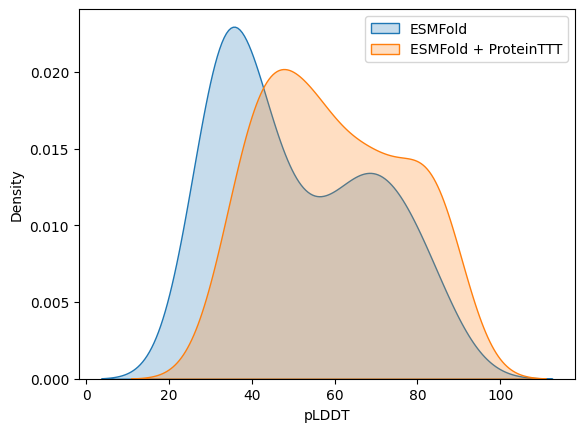

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

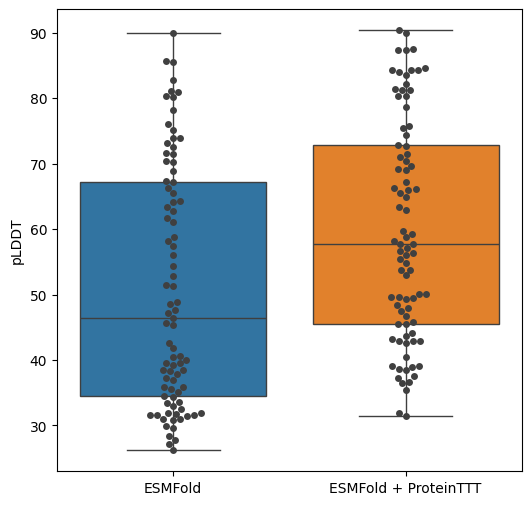

In [9]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['pLDDT_before', 'pLDDT_after']])
sns.swarmplot(data=sub_df[['pLDDT_before', 'pLDDT_after']], color=".25")
plt.ylabel('pLDDT')
plt.xticks([0, 1], ['ESMFold', 'ESMFold + ProteinTTT'])
plt.show()  

In [10]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    85.000000
 mean     50.970040
 std      18.292228
 min      26.214635
 25%      34.465891
 50%      46.402697
 75%      67.241621
 max      89.990320
 Name: pLDDT_before, dtype: float64,
 count    85.000000
 mean     59.817569
 std      16.730841
 min      31.419610
 25%      45.558490
 50%      57.731184
 75%      72.765469
 max      90.359866
 Name: pLDDT_after, dtype: float64)